<a href="https://www.kaggle.com/code/andriybabiy/02-image-classification-intel-image-classification?scriptVersionId=198709188" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

## Download and prepare the data for processing

In [2]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

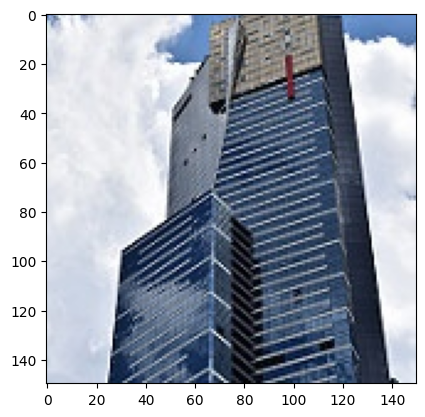

In [3]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Transformations

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.filenames = []
        self.labels = []
        self.class_names = []
        
        # Traverse the directory structure
        for root, dirs, files in os.walk(data_dir):
            # Get the class name based on the folder name
            class_name = os.path.basename(root)
            
            if len(files) > 0:
                # Append all file paths and assign labels based on folder name
                for filename in files:
                    if filename.endswith('.jpg'):
                        self.filenames.append(os.path.join(root, filename))
                        # Use the class name (parent folder name) as the label
                        if class_name not in self.class_names:
                            self.class_names.append(class_name)
                        label = self.class_names.index(class_name)
                        self.labels.append(label)
                        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_path = self.filenames[idx]
        image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
resize_size = (150, 150)

transform_train = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = ImageDataset(train, transform_train)
test_dataset = ImageDataset(test, transform)
val_dataset = ImageDataset(pred, transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

### Display image examples

In [8]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = next(dataiter)

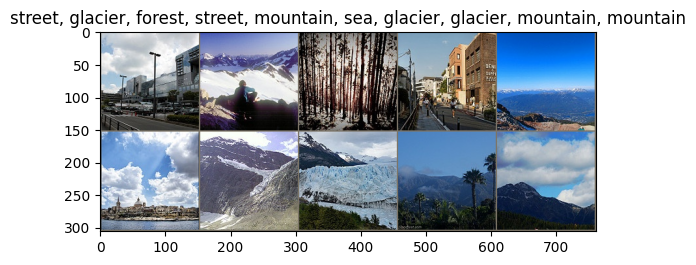

In [9]:
imshow(make_grid(images[:10], nrow=5), labels[:10], test_dataset.class_names)

### Insights about the classes

In [10]:
print(f"Amount of classes: {len(test_dataset.class_names)}")
print(f"Classes: {test_dataset.class_names}")
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

class_counts = {class_name: 0 for class_name in train_dataset.class_names}
for label in train_dataset.labels:
    class_counts[train_dataset.class_names[label]]+=1

print("\nDistribution of classes in the training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Amount of classes: 6
Classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']
Size of training dataset: 14034
Size of test dataset: 3000
Size of validation dataset: 7301

Distribution of classes in the training dataset:
mountain: 2512
street: 2382
buildings: 2191
sea: 2274
forest: 2271
glacier: 2404


## Develop the architecture for a convolutional neural network (CNN) for image classification

### Baseline Model

In [11]:
# class BaselineModel(nn.Module):
#     def __init__(self, ):
#         super().__init__()
#         self.num_channels = 32
        
#         self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
#         self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        
#         self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
#         self.fc2 = nn.Linear(self.num_channels*4, 6)
        
#     def forward(self, s):
#         s = self.conv1(s)
#         s = F.relu(F.max_pool2d(s, 2))
#         s = self.conv2(s)
#         s = F.relu(F.max_pool2d(s, 2))
#         s = self.conv3(s)
#         s = F.relu(F.max_pool2d(s, 2))
        
#         s = s.view(-1, 8*8*self.num_channels*4)
        
#         s = F.relu(self.fc1(s))
#         s = self.fc2(s)
        
#         return F.log_softmax(s, dim=1)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=36):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Обчислити розмір вхідних даних для повнозв'язного шару
        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        # Прокинемо зображення через конволюційні шари, щоб дізнатися розмір
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# cuda = torch.cuda.is_available()

# torch.manual_seed(42)
# if cuda:
#     cuda.manual_seed(42)

# device = 'cuda' if cuda else None

In [24]:
# model = BaselineModel().to(device)
model = SimpleCNN(num_classes=6)

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# train_losses = []
# train_accs = []

# test_losses = []
# test_accs = []

num_epochs = 15

best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [19]:
model

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=41472, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [25]:
# for epoch in tqdm(range(num_epochs)):
    
#     # train step
    
#     model.train()
    
#     train_epoch_loss = []
#     train_epoch_acc = []
    
#     for i, (train_batch, labels_batch) in tqdm(enumerate(train_loader)):
#         if cuda:
#             train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
#         output_batch = model(train_batch)
        
#         loss = criterion(output_batch, labels_batch)
        
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()
        
#         batch_loss = loss.cpu().detach().numpy()
#         batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                            labels_batch.cpu().detach().numpy())
        
#         train_epoch_loss.append(batch_loss)
#         train_epoch_acc.append(batch_acc)
        
        
#     # eval step
    
#     model.eval()
    
#     test_epoch_loss = []
#     test_epoch_acc = []
    
#     with torch.no_grad():
#         for i , (test_batch, labels_batch) in enumerate(test_loader):
#             if cuda:
#                 test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
#             output_batch = model(test_batch)
            
#             loss = criterion(output_batch, labels_batch)
            
#             batch_loss = loss.cpu().detach().numpy()
#             batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                                labels.batch.cpu().detach().numpy())
            
#             test_epoch_loss.append(batch_loss)
#             test_epoch_acc.append(batch_acc)
            
#     print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
#     test_accs.append(np.mean(test_epoch_acc))
#     test_losses.append(np.mean(test_epoch_loss))
    
    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')

100%|██████████| 439/439 [00:14<00:00, 31.27it/s]


Epoch 1/15:
Train Loss: 1.3642, Train Accuracy: 0.6605
Val Loss: 3.9526, Val Accuracy: 0.2168


100%|██████████| 439/439 [00:13<00:00, 31.86it/s]


Epoch 2/15:
Train Loss: 0.6127, Train Accuracy: 0.7771
Val Loss: 5.7159, Val Accuracy: 0.1381


100%|██████████| 439/439 [00:13<00:00, 31.69it/s]


Epoch 3/15:
Train Loss: 0.5466, Train Accuracy: 0.8013
Val Loss: 4.4872, Val Accuracy: 0.1631


100%|██████████| 439/439 [00:13<00:00, 31.61it/s]


Epoch 4/15:
Train Loss: 0.4941, Train Accuracy: 0.8241
Val Loss: 5.2735, Val Accuracy: 0.2660


100%|██████████| 439/439 [00:13<00:00, 31.59it/s]


Epoch 5/15:
Train Loss: 0.4630, Train Accuracy: 0.8328
Val Loss: 6.2314, Val Accuracy: 0.1496


100%|██████████| 439/439 [00:13<00:00, 31.44it/s]


Epoch 6/15:
Train Loss: 0.4316, Train Accuracy: 0.8462
Val Loss: 6.4347, Val Accuracy: 0.1490


100%|██████████| 439/439 [00:14<00:00, 31.03it/s]


Epoch 7/15:
Train Loss: 0.4030, Train Accuracy: 0.8556
Val Loss: 5.0928, Val Accuracy: 0.1635


100%|██████████| 439/439 [00:14<00:00, 31.20it/s]


Epoch 8/15:
Train Loss: 0.3816, Train Accuracy: 0.8602
Val Loss: 7.2007, Val Accuracy: 0.2124


100%|██████████| 439/439 [00:13<00:00, 31.52it/s]


Epoch 9/15:
Train Loss: 0.3513, Train Accuracy: 0.8743
Val Loss: 5.2165, Val Accuracy: 0.2250


100%|██████████| 439/439 [00:13<00:00, 31.50it/s]


Epoch 10/15:
Train Loss: 0.3201, Train Accuracy: 0.8873
Val Loss: 7.1350, Val Accuracy: 0.1492


100%|██████████| 439/439 [00:13<00:00, 31.58it/s]


Epoch 11/15:
Train Loss: 0.2965, Train Accuracy: 0.8913
Val Loss: 6.1775, Val Accuracy: 0.2108


100%|██████████| 439/439 [00:13<00:00, 31.64it/s]


Epoch 12/15:
Train Loss: 0.2797, Train Accuracy: 0.9003
Val Loss: 6.7573, Val Accuracy: 0.1926


100%|██████████| 439/439 [00:14<00:00, 31.04it/s]


Epoch 13/15:
Train Loss: 0.2572, Train Accuracy: 0.9092
Val Loss: 8.1442, Val Accuracy: 0.1375


100%|██████████| 439/439 [00:14<00:00, 31.21it/s]


Epoch 14/15:
Train Loss: 0.2262, Train Accuracy: 0.9181
Val Loss: 10.2835, Val Accuracy: 0.1405


100%|██████████| 439/439 [00:14<00:00, 30.79it/s]


Epoch 15/15:
Train Loss: 0.2057, Train Accuracy: 0.9268
Val Loss: 8.5417, Val Accuracy: 0.1998


## Train the model on the training dataset

## Analyze the effectiveness of the model using the valid and test datasets

In [26]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [27]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [28]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.7283
F1 Score: 0.7277


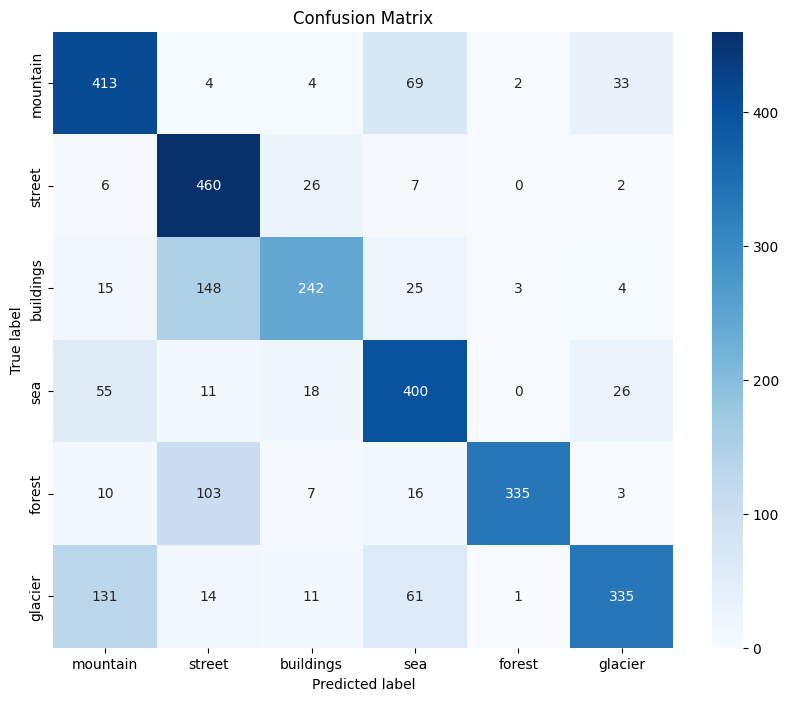

In [31]:
class_names = train_dataset.class_names

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

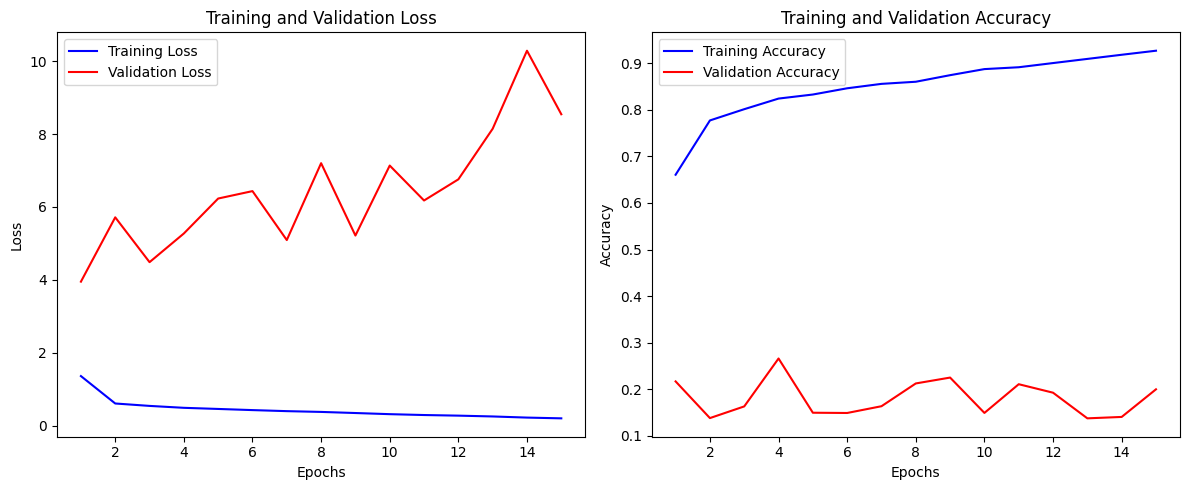

In [32]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

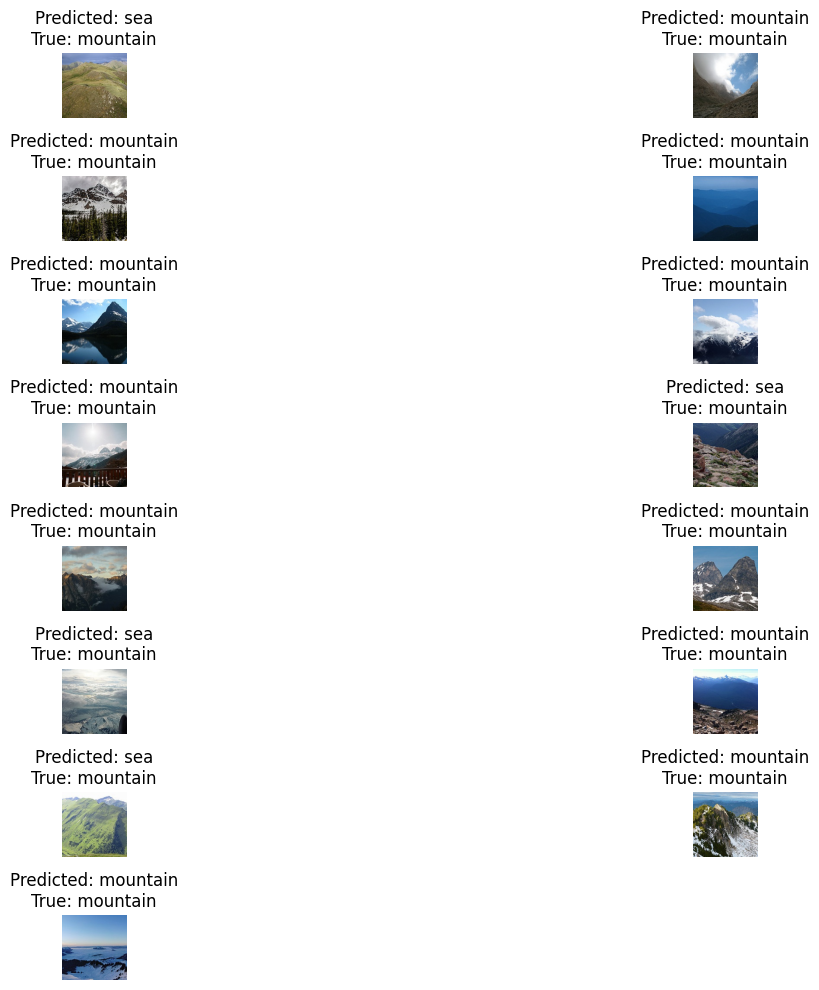

In [34]:
visualize_predictions(model, test_loader, train_dataset.class_names, 15)

## Analyze the results and proposal of further potential improvements of the model

After the initial run of the custom model, even during the state of training the model it was clearly evident that the model was overfitting as the model was improving its performance on the train dataset while slowly getting worse on the test dataset. 